## Examples using SCADRegression

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import torch

import torch.nn as nn
import torch.optim as optim
from scipy.linalg import toeplitz

from SCADRegression import SCADRegression
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
seed = 441 # Set seed for random generation

### Application using randomly generated dataset

In [3]:
# Simulate data
def true_model(X):
    return 2*X + 5

sample_size = 200

np.random.seed(seed)
noise = torch.tensor(np.random.normal(scale=0.3, size=sample_size))
X = torch.tensor(np.random.uniform(low=-1, high=1, size=sample_size))
y = true_model(X) + noise

(X.shape, y.shape)

(torch.Size([200]), torch.Size([200]))

In [4]:
scad = SCADRegression()
scad.fit(X, y)
y_pred = scad.predict(X)
mean_squared_error(y, y_pred)

0.07828288895345475

In [5]:
# Show coefficients of fitted model
coefs = scad.coefs_
print(f"y = {coefs[1]}x + {coefs[0]}")

y = 1.9747228304975486x + 4.994941530948604


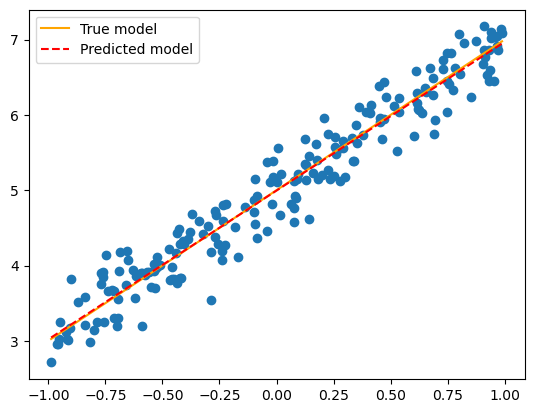

In [6]:
plt.scatter(X, y)

sorted_idx = X.argsort()
plt.plot(X[sorted_idx], true_model(X[sorted_idx]), color='orange', label='True model')
plt.plot(X[sorted_idx], y_pred[sorted_idx], color='red', ls='--', label='Predicted model')
plt.legend()
plt.show()

### Application using cars dataset

Get dataset here: https://gist.github.com/noamross/e5d3e859aa0c794be10b

In [7]:
data = pd.read_csv('../../data/cars.csv')
X = torch.tensor(data.drop('MPG', axis=1).values)
y = torch.tensor(data['MPG'].values)

(X.shape, y.shape)

(torch.Size([392, 3]), torch.Size([392]))

In [8]:
scad = SCADRegression()
scad.fit(X, y)
y_pred = scad.predict(X)
mean_squared_error(y, y_pred)

18.27214062515421

In [9]:
scad.coefs_

tensor([ 4.4474e+01, -2.9392e-01, -1.1983e-02, -5.7396e-03],
       dtype=torch.float64)

### Comparsion against ElasticNet and SqrtLasso

In [16]:
device = torch.device('cpu')
dtype = torch.double

In [30]:
class SqrtLasso(nn.Module):
    def __init__(self, input_size, alpha=0.1):
        """
        Initialize the  regression model.
        """
        super(SqrtLasso, self).__init__()
        self.input_size = input_size
        self.alpha = alpha

        # Define the linear regression layer
        self.linear = nn.Linear(input_size, 1,bias=False,device=device,dtype=dtype)


    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (Tensor): Input data with shape (batch_size, input_size).

        Returns:
            Tensor: Predicted values with shape (batch_size, 1).

        """
        return self.linear(x)


    def loss(self, y_pred, y_true):
        """
        Compute the loss function.

        Args:
            y_pred (Tensor): Predicted values with shape (batch_size, 1).
            y_true (Tensor): True target values with shape (batch_size, 1).

        Returns:
            Tensor: The loss.

        """
        mse_loss = nn.MSELoss(reduction='mean')(y_pred, y_true)
        l1_reg = torch.norm(self.linear.weight, p=1,dtype=torch.float64)

        loss = torch.sqrt(mse_loss) + self.alpha * (l1_reg)

        return loss


    def fit(self, X, y, num_epochs=200, learning_rate=0.01):
        """
        Fit the model to the training data.

        Args:
            X (Tensor): Input data with shape (num_samples, input_size).
            y (Tensor): Target values with shape (num_samples, 1).
            num_epochs (int): Number of training epochs.
            learning_rate (float): Learning rate for optimization.

        """
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            self.train()
            optimizer.zero_grad()
            y_pred = self(X)
            loss = self.loss(y_pred, y)
            loss.backward()
            optimizer.step()

            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")


    def predict(self, X):
        """
        Predict target values for input data.

        Args:
            X (Tensor): Input data with shape (num_samples, input_size).

        Returns:
            Tensor: Predicted values with shape (num_samples, 1).
        """
        self.eval()
        with torch.no_grad():
            y_pred = self(X)
        return y_pred
    

    def get_coefficients(self):
        """
        Get the coefficients (weights) of the linear regression layer.

        Returns:
            Tensor: Coefficients with shape (output_size, input_size).
        """
        return self.linear.weight

In [31]:
def simulate_data(p:int, n:int, rho:float):
    '''
    Randomly generate a linearly correlated dataset.

    Args:
        p: Number of predictors
        n: Number of samples
        rho: Covariance
    '''
    np.random.seed(441)
    X = make_correlated_features(n,p,rho)

    beta = np.random.uniform(low=-5, high=5, size=10).reshape(-1,1)
    betas = np.concatenate([beta, np.zeros(p-len(beta)).reshape(-1,1)], axis=0) # \beta^*
    y = X@betas + 0.5*np.random.normal(size=(X.shape[0], 1))
    return X, y

def make_correlated_features(p:int, num_samples:int, rho:float):
    vcor = [] 
    for i in range(p):
        vcor.append(rho**i)
    r = toeplitz(vcor) # Covariance
    mu = np.zeros(p)
    x = np.random.multivariate_normal(mu, r, size=num_samples)
    return x

In [33]:
p = 20 # Number of predictors
n = 150 # Number of observations
rho = 0.9
n_iters = 500 # Number of sample datasets to simulate and test

# Store mean squared errors of results from training and testing data
# SCADRegression
scad_tr_mses = []
scad_te_mses = []
# ElasticNet
en_tr_mses = []
en_te_mses = []
# SqrtLasso
sl_tr_mses = []
sl_te_mses = []

for iter in range(n_iters):
    X, y = simulate_data(p, n, rho)

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=seed)
    Xtrain = torch.tensor(Xtrain, dtype=dtype)
    Xtest = torch.tensor(Xtest, dtype=dtype)
    ytrain = torch.tensor(ytrain, dtype=dtype)
    ytest = torch.tensor(ytest, dtype=dtype)

    scad = SCADRegression()
    scad.fit(Xtrain, ytrain)
    scad_tr_mses.append(mean_squared_error(ytrain, scad.predict(Xtrain)))
    scad_te_mses.append(mean_squared_error(ytest, scad.predict(Xtest)))

    elastic_net = ElasticNet()
    elastic_net.fit(Xtrain, ytrain)
    en_tr_mses.append(mean_squared_error(ytrain, elastic_net.predict(Xtrain)))
    en_te_mses.append(mean_squared_error(ytest, elastic_net.predict(Xtest)))

    sqrt_lasso = SqrtLasso(input_size=X.shape[1])
    sqrt_lasso.fit(Xtrain, ytrain)
    sl_tr_mses.append(mean_squared_error(ytrain, sqrt_lasso.predict(Xtrain)))
    sl_te_mses.append(mean_squared_error(ytest, sqrt_lasso.predict(Xtest)))

Epoch [100/200], Loss: 4.226035283671707
Epoch [200/200], Loss: 3.033913407659085
Epoch [100/200], Loss: 4.000551231379265
Epoch [200/200], Loss: 2.881636757311791
Epoch [100/200], Loss: 3.8517736714032895
Epoch [200/200], Loss: 2.8322157635088683
Epoch [100/200], Loss: 4.044485225269644
Epoch [200/200], Loss: 2.9701326806748996
Epoch [100/200], Loss: 3.947531066378897
Epoch [200/200], Loss: 2.9330240445197844
Epoch [100/200], Loss: 4.041866460707804
Epoch [200/200], Loss: 2.8982421142067563
Epoch [100/200], Loss: 4.1298633080415135
Epoch [200/200], Loss: 3.026535001223217
Epoch [100/200], Loss: 4.1081698054457805
Epoch [200/200], Loss: 2.977796887737219
Epoch [100/200], Loss: 4.0431182834468
Epoch [200/200], Loss: 2.9489767707569823
Epoch [100/200], Loss: 4.063820286072454
Epoch [200/200], Loss: 2.9537659306826027
Epoch [100/200], Loss: 3.917299295462187
Epoch [200/200], Loss: 2.831728744287154
Epoch [100/200], Loss: 3.963415757006205
Epoch [200/200], Loss: 2.877425320770017
Epoch [10

In [35]:
# Get average mean squared errors from SCADRegression results
(np.mean(scad_tr_mses), np.mean(scad_te_mses))

(72.51849237913609, 46.892432729953754)

In [36]:
# MSEs from ElasticNet
(np.mean(en_tr_mses), np.mean(en_te_mses))

(5.537145738827632, 2.5184947604387973)

In [37]:
# MSEs from SqrtLasso
(np.mean(sl_tr_mses), np.mean(sl_te_mses))

(3.9548679731682683, 2.0091295331839154)